In [1]:
#%% 라이브러리
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns

In [11]:
import warnings
# 경고메세지 끄기
warnings.filterwarnings(action='ignore')

# # 다시 출력하게 하기
# warnings.filterwarnings(action='default')

# Load data

In [5]:
filepath = "./"
df = pd.read_csv(filepath+'Practice_B_Data.csv',index_col='Time')
Input1 = pd.DataFrame(df) 


In [30]:
Input1

,SA 온도 설정값,SA 온도,SA 온도 셋편차,밸브 오프닝,냉수 공급온도,냉수 온도차,냉수 유량,냉동기 전력량
Time,,,,,,,,
23.06.2022 11:44,15,24.39375,10.39375,100,19.6,0.1,2.46,0.09
23.06.2022 11:45,14,24.39375,10.39375,100,19.6,0.1,2.46,0.09
23.06.2022 11:46,14,23.79375,9.79375,100,19.4,0.0,2.47,0.09
23.06.2022 11:47,14,23.09375,9.09375,100,19.7,0.0,2.46,0.09
23.06.2022 11:48,14,22.49375,8.49375,100,17.2,2.6,2.93,4.57
...,...,...,...,...,...,...,...,...
24.06.2022 21:21,14,11.23750,-2.76250,31,6.1,3.6,2.26,3.33
24.06.2022 21:22,14,10.84375,-3.15625,31,5.8,3.6,2.26,3.33
24.06.2022 21:23,14,10.63750,-3.36250,31,5.6,3.4,2.25,3.33


# Preprocessing

In [8]:
#%% Preprocessing

def preprocessing_(Selected,Z_score_threshold,SF_factor):
    from scipy import stats
    
    # z-score outlier removal
    Selected_z = Selected  # pandas dataframe
    z_score = np.abs(stats.zscore(Selected_z,nan_policy='omit'))
    Selected_zscore = Selected_z[(z_score < Z_score_threshold).all(axis=1)]
    [a,b] = np.shape(Selected)
    [a1,b1] = np.shape(Selected_zscore)
    removed_zscore = a-a1
    print("Z-score outlier removal process complete... \x0A▼\x0A")
    print(removed_zscore,"samples are removed\x0A")
    
    # process
    pp_data = np.array(Selected_zscore)
    [row, col] = np.shape(pp_data)
    pp_data = pd.DataFrame(pp_data)
    
    # Save normalize boundary
    pp_data_Norm = np.array(pp_data)
    norm_bound = np.zeros((col,2))
    for i in range(0,col):
        norm_bound[[i],0] = [[pp_data_Norm[:,i].min()-(pp_data_Norm[:,i].std())*SF_factor]] # Lower bound..(S.F 0.1 of mean)
        norm_bound[[i],1] = [[pp_data_Norm[:,i].max()+(pp_data_Norm[:,i].std())*SF_factor]] # Upper bound..(S.F 0.1 of mean)
    norm_bound=pd.DataFrame(norm_bound,columns = ['min','max'],)
    
    # Min-max normalization
    Loaded_bound = pd.DataFrame(norm_bound)
    Loaded_bound = np.array(Loaded_bound)
    Testing_Normalize = np.zeros(pp_data_Norm.shape)
    for i in range(0,pp_data_Norm.shape[1]):
        Testing_Normalize[:,[i]] = (pp_data_Norm[:,[i]]-Loaded_bound[[i],0])/(Loaded_bound[[i],1]-Loaded_bound[[i],0])
    print("Min-max normalization complete:\x0A▼\x0A")
    
    return Testing_Normalize, Selected_zscore,norm_bound

# Input data

In [9]:
# Input data ===================================================================
Input, Selected_zscore, norm_bound = preprocessing_(Input1,100,1)

Input = pd.DataFrame(Input)
Input.index = Selected_zscore.index
Input.columns = Selected_zscore.columns

#%% K-means clustering
plt.rcParams['font.family'] = "times new roman"

Z-score outlier removal process complete... 
▼

0 samples are removed

Min-max normalization complete:
▼



# K 정하는 방법

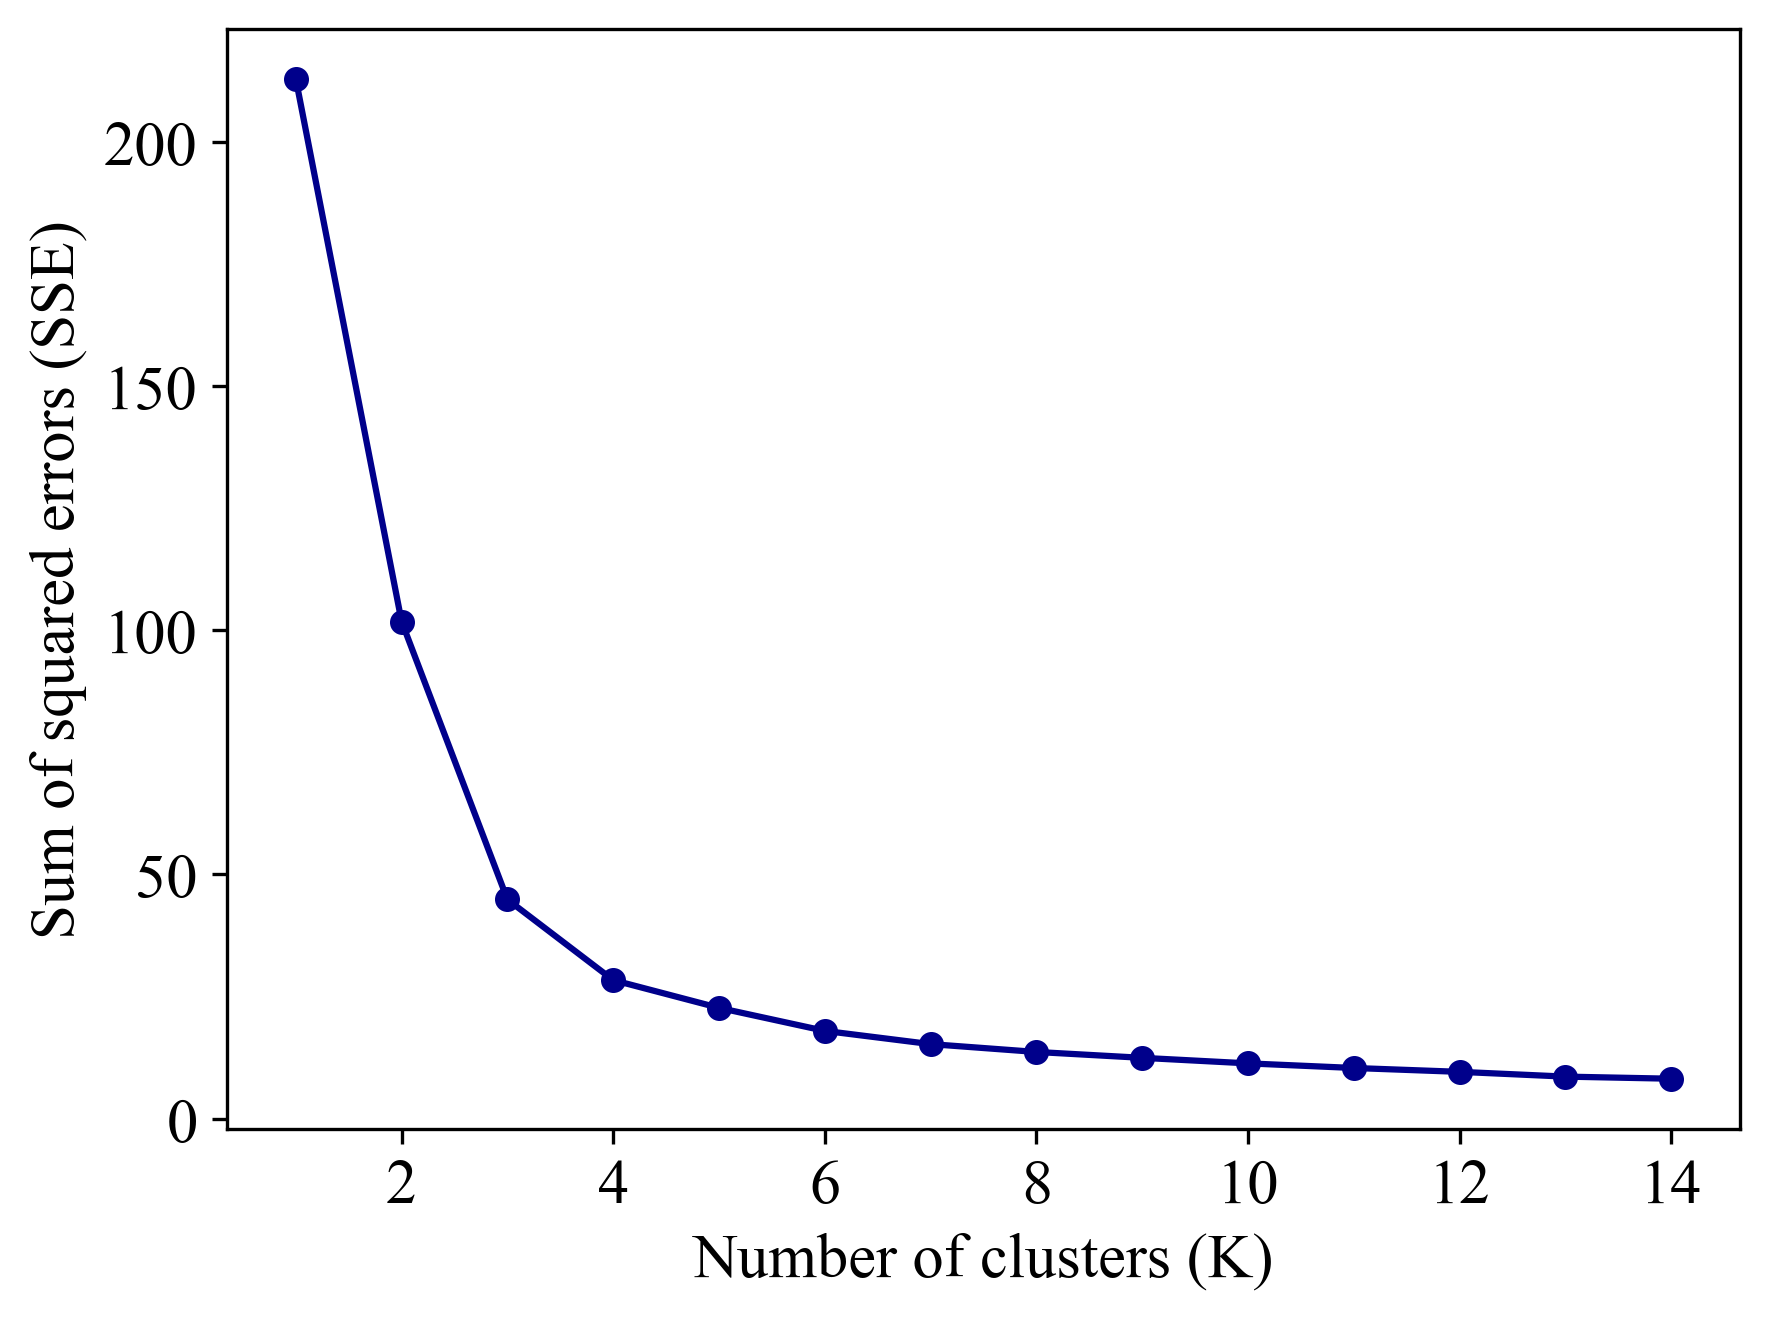

In [12]:
#### K 정하는 방법 ==============================================================
## Elbow method
fig = plt.figure(figsize = (6,4.5),dpi=300)

def elbow(X):
    sse = []

    for i in range(1,15):
        km = KMeans(n_clusters=i,algorithm='auto',random_state=500)
        km.fit(X)
        sse.append(km.inertia_)

    plt.plot(range(1,15), sse,
              color='darkblue',
              marker='o',markersize=5,)
    plt.xlabel('Number of clusters (K)',fontsize=15)
    plt.ylabel('Sum of squared errors (SSE)',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    fig.tight_layout()
    plt.show()

elbow(Input)

# Davies-Bouldin index

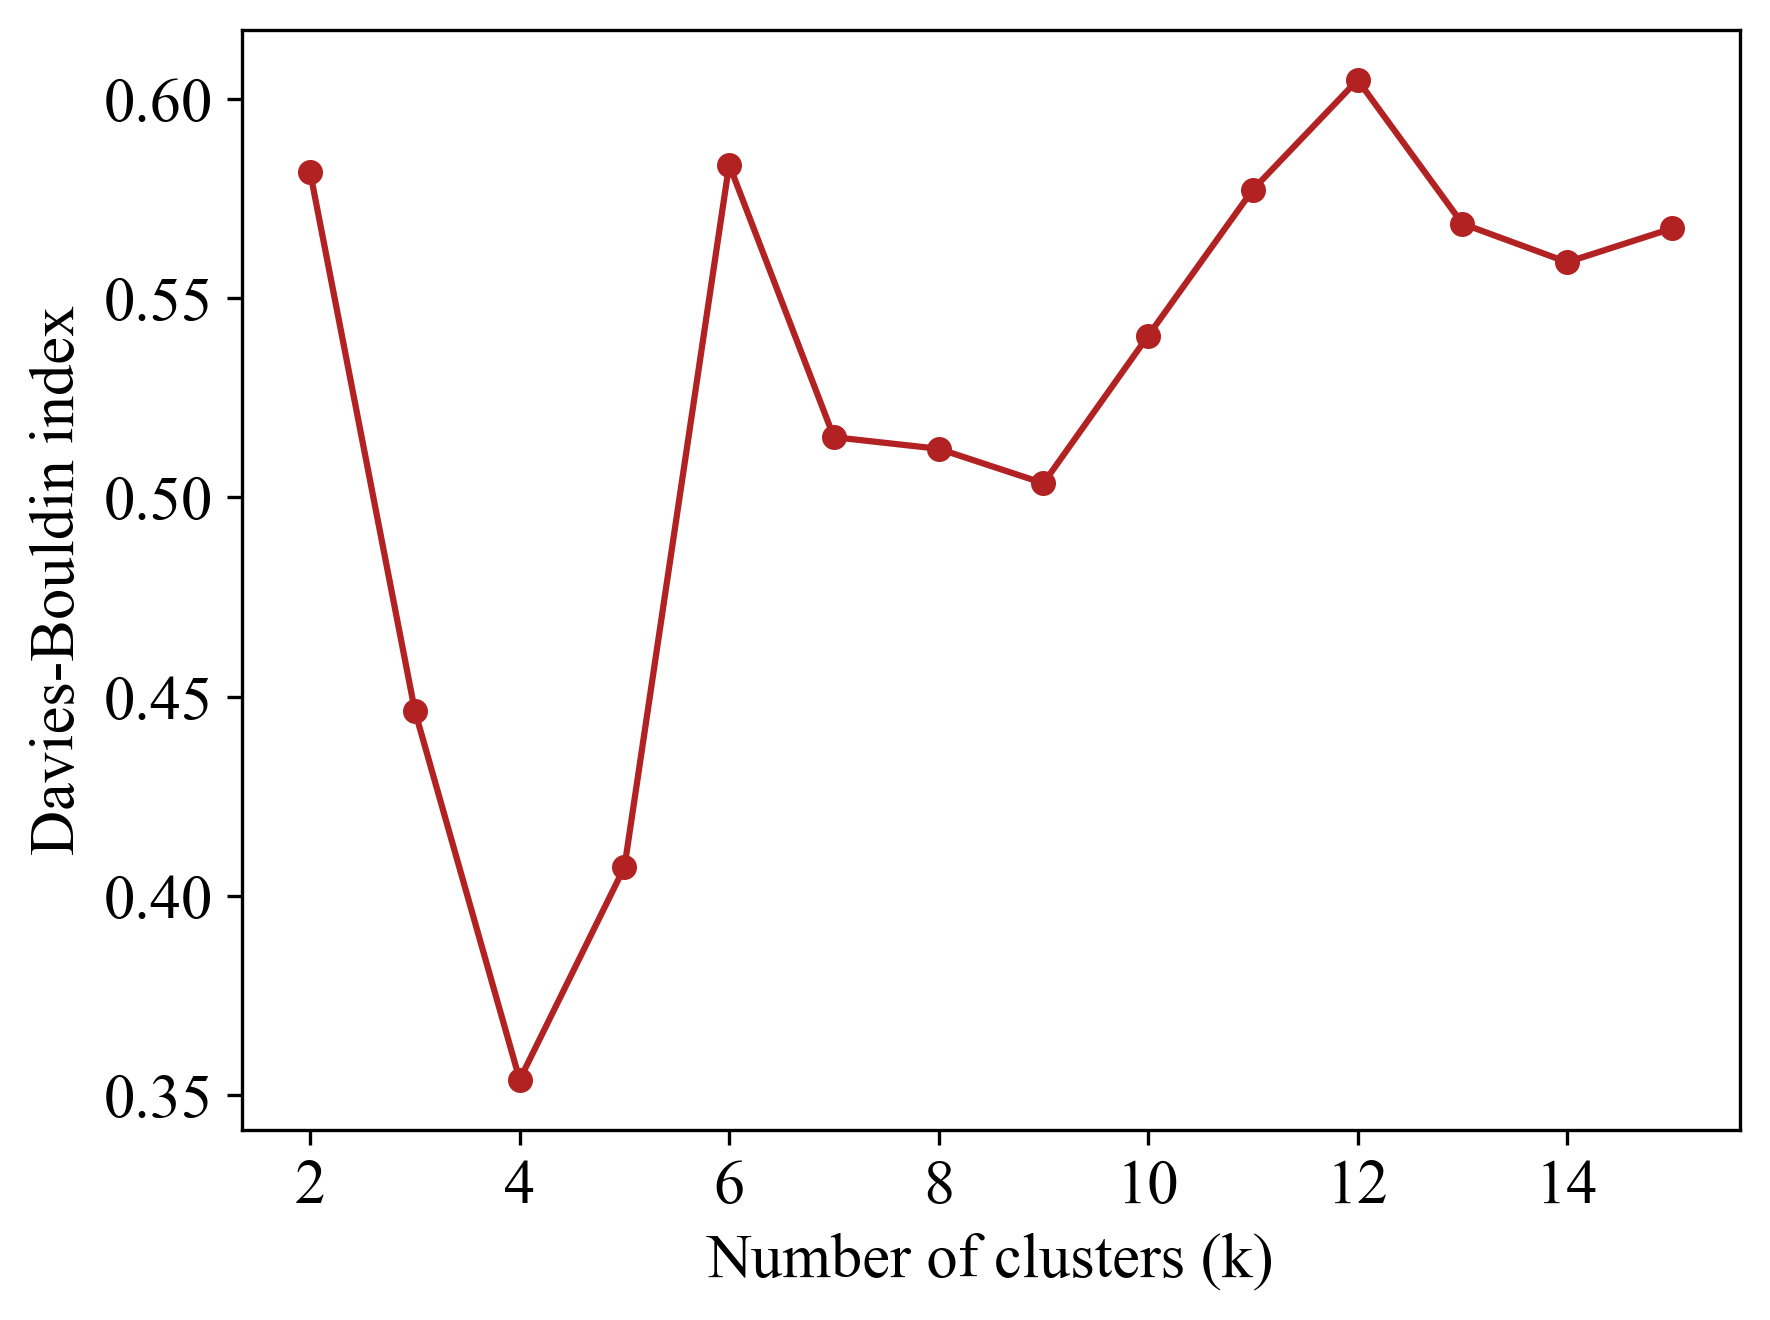

In [13]:
from sklearn.metrics import davies_bouldin_score

fig = plt.figure(figsize = (6,4.5),dpi=300)

def DBI_(X):
    db = []
    for k in range(2,16):
        kmeans = KMeans(n_clusters=k, max_iter=100,random_state=10).fit(X)
        clusters = kmeans.labels_
        db.append(davies_bouldin_score(X,clusters))
    
    plt.plot(range(2,16), db,
              color='firebrick',
              marker='o',markersize=5)
    plt.xlabel('Number of clusters (k)',fontsize=15)
    plt.ylabel('Davies-Bouldin index',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    fig.tight_layout()
    plt.show()
    return db

db = DBI_(Input.loc[:,["SA 온도 셋편차","밸브 오프닝","냉동기 전력량"]])

# Kmeans Model

In [27]:
Num_clusters=10

In [22]:
Model_Kmeans = KMeans(n_clusters=Num_clusters,algorithm='auto',random_state=20)

predict_Kmeans = pd.DataFrame(Model_Kmeans.fit_predict(Input.loc[:,["SA 온도 셋편차","밸브 오프닝","냉동기 전력량"]]))
predict_Kmeans.columns=['predict_Kmeans']
predict_Kmeans.index = Input1.index

print("\x0A")
print("kmeans Clustering precess complete...\x0A▼")



kmeans Clustering precess complete...
▼


In [23]:
#%% Cluster list

Data = pd.concat([Input1,predict_Kmeans],axis=1) 


Cluster_list = list()
for i in range(0,Num_clusters):
    Cluster_list.append(Data[Data['predict_Kmeans']==i].drop('predict_Kmeans',axis = 1))

In [24]:
#%% 색지정

Color = ['firebrick','darkorange','olivedrab','teal','mediumpurple','palevioletred','steelblue','grey','magenta','blue']
xlabel = ['HOS 1','HOS 2','HOS 3','HOS 4','HOS 5','HOS 6','HOS 7','HOS 8','HOS 9','HOS 10']


# Combine the all fig

## Basic setting

In [25]:
# Basic setting ===============================================================

# plot 1 (스케쥴)
Index_count = pd.DataFrame(np.zeros((24,Num_clusters)),
                            index = range(0,24),
                            columns = range(0,Num_clusters))
for i in range(0,Num_clusters):
    Index_count.loc[:,i]=Cluster_list[i].index.str[11:13].astype(int).value_counts()
    
# plot 2 (부분부하율)
DeltaT_percent_list = list()
for i in range(0,Num_clusters):
    DeltaT_percent_list.append(Cluster_list[i]['냉동기 전력량']/7.7*100)

## Plotting

In [26]:
# Plotting ====================================================================

column_titles = ["Schedule", "Partial load", "Control error", "Control behavior", "External variable 1", "External variable 2"]
row_titles = ["HOS {}".format(i+1) for i in range(Num_clusters)]

gs = fig.add_gridspec(Num_clusters, 7, width_ratios=[1, 1, 1, 1, 1, 1, 0.05])

fig, axes = plt.subplots(Num_clusters, 6, figsize=(40, Num_clusters*5), dpi=300)

for i in range(Num_clusters):
    # Add row title
    ax_title = fig.add_subplot(gs[i, 0])
    ax_title.text(-0.3, 0.5, row_titles[i], fontsize=28, fontweight='bold', ha='center', va='center')
    ax_title.axis('off')
    
    # Plot for 스케쥴 =========================================================
    axes[i, 0].bar(range(0, 24), Index_count.iloc[:, i],
                   color=Color[i],
                   edgecolor='k',
                   label=xlabel[i])
    axes[i, 0].legend(loc='upper right', fontsize=15)
    axes[i, 0].set_xlabel('Time (hh)', fontsize=23)
    axes[i, 0].set_ylabel('Number of samples', fontsize=23)
    axes[i, 0].set_xticks(np.linspace(0, 22, 12, endpoint=False))
    axes[i, 0].set_xlim(0, 22)
    axes[i, 0].set_ylim(0, 120)
    axes[0, 0].set_title(column_titles[0], fontsize=28,fontweight='bold')
        
        
    # Plot for 부분부하율 =====================================================
    axes[i, 1].hist(DeltaT_percent_list[i], bins=np.linspace(0, 100, 20),
                        color=Color[i],
                        rwidth=1, edgecolor='k', density=True,
                        label=xlabel[i])
    axes[i, 1].legend(loc='upper right', fontsize=15)
    axes[i, 1].set_xlabel('Partial load ratio (%)', fontsize=23)
    axes[i, 1].set_ylabel('PDF', fontsize=23)
    axes[i, 1].set_xlim(0, 100)
    axes[i, 1].set_ylim(0, 0.08)
    axes[0, 1].set_title(column_titles[1], fontsize=30,fontweight='bold')
        
    # Plot for 제어 편차 ======================================================
    axes[i, 2].hist(Cluster_list[i]['SA 온도'].astype(float),
            bins=np.linspace(0,100,60),
            color='darkmagenta',
            rwidth=1,
            edgecolor='k',
            density=True,
            label='Measure temperature')
    axes[i, 2].hist(Cluster_list[i]['SA 온도 설정값'].astype(float),
            bins=np.linspace(0,100,60),
            color='lightpink',
            alpha=0.6,
            rwidth=1,
            edgecolor='k',
            density=True,
            label='Set temperature')
    axes[i, 2].legend(loc='upper right',fontsize=15)
    axes[i, 2].set_xlabel('Temperature (°C)', fontsize=23)
    axes[i, 2].set_ylabel('PDF', fontsize=23)
    axes[i, 2].set_xlim(0,30)
    axes[i, 2].set_ylim(0,0.5)
    axes[0, 2].set_title(column_titles[2], fontsize=30,fontweight='bold')
        
    # Plot for 제어 동작 ======================================================
    axes[i, 3].scatter(Cluster_list[i]['SA 온도 셋편차'],Cluster_list[i]['밸브 오프닝'],
                    color=Color[i],
                    marker='o',s=100,edgecolor='k',
                    label = xlabel[i])
    axes[i, 3].legend(loc='upper left',fontsize=13)
    axes[i, 3].set_xlabel('SA Set temperature difference (°C)',fontsize=23)
    axes[i, 3].set_ylabel('Valve opening (%)',fontsize=23)
    axes[i, 3].set_xlim(-8,12)
    axes[i, 3].set_ylim(0,102)
    axes[0, 3].set_title(column_titles[3], fontsize=30,fontweight='bold')
        
    # Plot for 냉수유량 =======================================================
    sns.boxplot(x=Cluster_list[i]['냉수 유량'], ax=axes[i, 4],
                    orient='h',
                    width=0.5,
                    color=Color[i])
    axes[i, 4].set_xlabel('Chilled water flow (CMH)',fontsize=23)
    axes[i, 4].set_ylabel(xlabel[i],fontsize=23)
    axes[i, 4].set_xlim(-0,3.6)
    axes[0, 4].set_title(column_titles[4], fontsize=30,fontweight='bold')
            
    # Plot 냉수 공급 온도 =====================================================
    sns.boxplot(x=Cluster_list[i]['냉수 공급온도'], ax=axes[i, 5],
                    orient='h',
                    width=0.5,
                    color=Color[i])
    axes[i, 5].vlines(5.5,-0.5,0.5,color='red',linestyle='--')
    axes[i, 5].vlines(8.5,-0.5,0.5,color='red',linestyle='--', label='Design range')
    axes[i, 5].legend(loc='upper right',fontsize=15)
    axes[i, 5].set_xlabel('Chilled water supply temperature (℃)',fontsize=23)
    axes[i, 5].set_ylabel(xlabel[i],fontsize=23)
    axes[i, 5].set_xlim(0,25)
    axes[0, 5].set_title(column_titles[5], fontsize=30,fontweight='bold')
                
# Adjust layout
plt.tight_layout()
plt.show()
